# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples = 5):
    ### STUDENT START ###
    example = 0
    while example <= 5:
        text = train_data[example]
        labels = train_labels[example]
        print('THIS IS THE TEXT FOR EXAMPLE ', example, ' WITH LABEL', labels, ':')
        print('\n')
        print(text)
        print('\n')
        example += 1
    ### STUDENT END ###
        
P1()

THIS IS THE TEXT FOR EXAMPLE  0  WITH LABEL 1 :


Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


THIS IS THE TEXT FOR EXAMPLE  1  WITH LABEL 3 :




Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstra

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [209]:
def P2():
    ### STUDENT START ###
    
    #PART 1
    vect1 = CountVectorizer()
    vect1_fit = vect1.fit_transform(train_data)
    vect1_feature_names = vect1.get_feature_names()
    #what is the size of the vocabulary?
    vocab_size = len(vect1_feature_names)
    print('the size of the vocabulary is: ', vocab_size)
    # What is the average number of non-zero features per example? 
    avg_num_non_zeros = vect1_fit.nnz / float(len(train_data))
    print('the average number of non-zero features per example is: ', np.round(avg_num_non_zeros, 3), '%')
    #What is the fraction of the non-zero entries in the matrix? 
    non_zeros = vect1_fit.nnz / (vect1_fit.shape[0] * vect1_fit.shape[1])
    print('the fraction of non-zero entries in the matrix: ', non_zeros)
    #What are the 0th and last feature strings (in alphabetical order)?
    zeroth = vect1_feature_names[0]
    last = vect1_feature_names[vocab_size-1]
    print('the 0th feature: ', zeroth, ' & the last feature: ', last)
    
    #PART 2
    words =  ["atheism", "graphics", "space", "religion"]
    vect_words = CountVectorizer(vocabulary = words)
    vect_words_transformed = vect_words.transform(train_data)
    # Confirm the size of the vocabulary. What is the average number of non-zero features per example?
    avg_num_non_zeros_words = vect_words_transformed.nnz / float(len(train_data))
    print('the average number of non-zero features per example with the given vocabulary: ', np.round(avg_num_non_zeros_words, 3))

    #PART 3
    vect_char = CountVectorizer(ngram_range = (2,3), analyzer = 'char')
    vect_char_fit = vect_char.fit_transform(train_data)
    print('the size of the vocabulary of the character bigram and trigram feature vectors: ', len(vect_char.get_feature_names()))
    
    #PART 4
    vect4 = CountVectorizer(min_df=10)
    vect4_fit = vect4.fit_transform(train_data)
    print('the size of the vocabulary of word unigram feature vectors that appear in fewer than 10 documents: ', len(vect4.get_feature_names()))
    
    #PART 5
    vect5 = CountVectorizer()
    vect5_fit = vect5.fit_transform(train_data)
    vect5_vocab = len(vect5.get_feature_names())
    
    vect6 = CountVectorizer()
    vect6_fit = vect6.fit_transform(dev_data)
    vect6_vocab = len(vect6.get_feature_names())
    
    print('the difference between train_data vocab and dev_data vocab: ', vect5_vocab - vect6_vocab)
    
    ### STUDENT END ###

P2()

the size of the vocabulary is:  26879
the average number of non-zero features per example is:  96.706 %
the fraction of non-zero entries in the matrix:  0.0035978272269590263
the 0th feature:  00  & the last feature:  zyxel
the average number of non-zero features per example with the given vocabulary:  0.268
the size of the vocabulary of the character bigram and trigram feature vectors:  35478
the size of the vocabulary of word unigram feature vectors that appear in fewer than 10 documents:  3064
the difference between train_data vocab and dev_data vocab:  10633


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
#step 1: transform data into word unigram feature vectors
def transform(data1, data2):
        vect = CountVectorizer()
        vect_fit = vect.fit_transform(data1)
        vect_trans = vect.transform(data2)
        return [vect_fit, vect_trans]

train_transform = transform(train_data, dev_data)[0]
dev_transform = transform(train_data, dev_data)[1]

In [6]:
#step 2: Produce several k-Nearest Neigbors models by varying k, 
# including one with k set to optimize f1 score. 
# For each model, show the k value and f1 score.

def knn(data1, labels1, data2, labels2):
    k_values = [5, 10, 20, 98, 102, 103]
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors = k)
        model.fit(data1, labels1)
        model_predict = model.predict(data2)
        f1 = metrics.f1_score( labels2, model_predict, average="weighted")
        print('WHEN k = ', k, ' THE f1 SCORE IS : ', np.round(f1, 4))

In [7]:
#step 3 Produce several Naive Bayes models by varying smoothing (alpha), 
#including one with alpha set approximately to optimize f1 score. 
#For each model, show the alpha value and f1 score.

def mnb(data1, labels1, data2, labels2):
    alphas = [0.01, 0.09, 0.1, 0.12, 0.2]
    for a in alphas:
        model = MultinomialNB(alpha = a)
        model.fit(data1, labels1)
        model_predict = model.predict(data2)
        f1 = metrics.f1_score( labels2, model_predict, average="weighted")
        print('FOR ALPHA = ', a, ' THE f1 SCORE : ', np.round(f1, 4))

In [8]:
# step 4: Produce several Logistic Regression models by varying L2 regularization strength (C), 
#including one with C set approximately to optimize f1 score.
#For each model, show the C value, f1 score, and sum of squared weights for each topic.

def logit(data1, labels1, data2, labels2):
    strength = [0.01, 0.1, 0.3, 0.5, 0.75]
    for s in strength:
        model = LogisticRegression(C= s, solver="liblinear", multi_class="auto")
        model.fit(data1, labels1)
        model_predict = model.predict(data2)
        f1 = metrics.f1_score(labels2, model_predict, average = "weighted")
        print('FOR C = ', s, ' THE f1 SCORE : ', np.round(f1,4))
        print('& THE SUM OF SQUARED WEIGHTS : ', np.sum(model.coef_**2))


In [9]:
#def P3():
    ### STUDENT START ###
    ### STUDENT END ###

#P3()

print('K NEAREST NEIGHBORS MODELS')
knn(train_transform, train_labels, dev_transform, dev_labels)
print('For the K-Nearest Neighbors mode, the f1 score is optimized when k = 98 & the optimized f1 score = 0.4525')
print('')
print('MULTINOMIAL NAIVE BAYES MODELS')
mnb(train_transform, train_labels, dev_transform, dev_labels)
print('For the Multinomial Naive Bayes model, the f1 score is optimized when alpha = 0.12 & the optimized f1 score = 0.7874')
print('')
print('LOGISTIC REGRESSION MODELS')
logit(train_transform, train_labels, dev_transform, dev_labels)
print('For the Logistic Regression model, the f1 score is optimized when C = 0.3 & the optimized f1 score = 0.696')



K NEAREST NEIGHBORS MODELS
WHEN k =  5  THE f1 SCORE IS :  0.4288
WHEN k =  10  THE f1 SCORE IS :  0.4279
WHEN k =  20  THE f1 SCORE IS :  0.4243
WHEN k =  98  THE f1 SCORE IS :  0.4491
WHEN k =  102  THE f1 SCORE IS :  0.4485
WHEN k =  103  THE f1 SCORE IS :  0.4499
For the K-Nearest Neighbors mode, the f1 score is optimized when k = 98 & the optimized f1 score = 0.4525

MULTINOMIAL NAIVE BAYES MODELS
FOR ALPHA =  0.01  THE f1 SCORE :  0.7752
FOR ALPHA =  0.09  THE f1 SCORE :  0.79
FOR ALPHA =  0.1  THE f1 SCORE :  0.7903
FOR ALPHA =  0.12  THE f1 SCORE :  0.7885
FOR ALPHA =  0.2  THE f1 SCORE :  0.7876
For the Multinomial Naive Bayes model, the f1 score is optimized when alpha = 0.12 & the optimized f1 score = 0.7874

LOGISTIC REGRESSION MODELS
FOR C =  0.01  THE f1 SCORE :  0.6647
& THE SUM OF SQUARED WEIGHTS :  10.593680011860615
FOR C =  0.1  THE f1 SCORE :  0.6966
& THE SUM OF SQUARED WEIGHTS :  102.28104455559837
FOR C =  0.3  THE f1 SCORE :  0.7101
& THE SUM OF SQUARED WEIGHTS 

ANSWER: 

Why doesn't k-Nearest Neighbors work well for this problem?
Documents that should be classified differently will have many similar words. Each of these words hold the same weight  as features and this will cause many similar distances & much inaccuracy.
Using k-Nearest Neighbors classification, we classify data based on the distances of other data points & their corresponding labels. When classifying documents to topics, CountVectorizer will create vectors only out of the data in our training set. These word unigram vectors become a set of features that is much smaller than the set of all features (there are basically an infinite number of words that could be used as features). Because of this our dimensions are much smaller and the classification accuracy will be much lower.

Why doesn't Logistic Regression work as well as Naive Bayes does?
Logistic Regression is a discriminative model and aims to find the decision boundary in the data while Naive Bayes is a generative model and aims to find the posterior probability that data belongs to a class. Because the features in the data would be expected to overlap quite a bit, finding a decision boundary is much more difficult as the features overlap- and the logistic regression model decreases the weights of features that are correlated with eachother.

What is the relationship between logistic regression's sum of squared weights vs. C value?
The C value represents the regularization strength of the logistic regression model. Changing the value of C will affect how feature weights are manipulated during the training step. C = 1/lambda- and low values of C will allow the model to increase in complexity leading to overfitting & higher values of C will keep the model from becoming too complex and can lead to underfitting. This happens because the C value tells the model how much weight to give its parameters- low values of C mean more weight given to parameters and more overfitting whereas high values of C mean less weight given to parameters and more underfitting. 

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [10]:
#function from part 3
def transform_p3(data):
    vect = CountVectorizer(ngram_range = (2,2))
    vect_fit = vect.fit_transform(data)
    vect_words = vect.get_feature_names()
    return vect_fit , vect_words

transform = transform_p3(train_data)
train_transform = transform[0]
train_transform_words = transform[1]

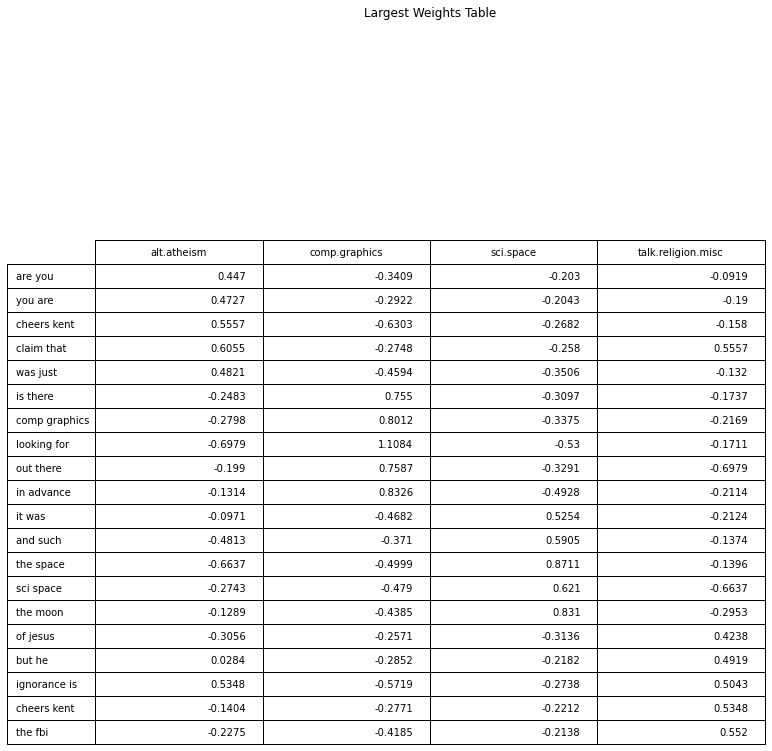

In [11]:
def P4():
    ### STUDENT START ###
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(train_transform, train_labels)
    
    weights_indices = np.argpartition(model.coef_, -5)[:,-5:]
    features = []
    for i in weights_indices:
           for x in i:
                features.append(train_transform_words[x])            
    
    topic_1 = np.round(np.take(model.coef_[0], weights_indices),4)
    topic_2 = np.round(np.take(model.coef_[1], weights_indices),4)
    topic_3 = np.round(np.take(model.coef_[2], weights_indices),4)
    topic_4 = np.round(np.take(model.coef_[3], weights_indices),4)
    
    column_values = np.column_stack((topic_1, topic_2, topic_3, topic_4)).T
    column_labels = ["alt.atheism", "comp.graphics", "sci.space", "talk.religion.misc"]
    
    table = plt.table(cellText = column_values, colLabels = column_labels, rowLabels = features)
    table.scale(2,2)
    plt.title('Largest Weights Table')
    plt.axis('off')
    plt.grid(False)
    plt.show()
    ### STUDENT END ###
P4()

ANSWER: It is odd that some of the features are flipped versions of themselves (ie. "are you" and "you are")- but this can be expected because we are transforming data into word bigram feature vectors. I also think it is interesting that 'are you' and 'you are' are have the largest weights in the 'alt.atheism' topic. Something else I found surprising was the incidence of 'cheers kent' in the 'alt.atheism' and 'talk.religion.misc' categories because I think this is a random pair of words I wouldn't have guessed, but it leads me to believe that there could be some kind of error here or that documents classified as the atheist topic are also classified as the religion topic.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [12]:
from nltk.stem import *

In [161]:
#transform the data into feature vectors without preprocessing
#set lowercase to False because default is true
#get train, dev, and vocab from this tranformation

def no_preprocessing(data):
    return data

def transform(data1, data2):
        vect = CountVectorizer(preprocessor = no_preprocessing)
        vect_fit = vect.fit_transform(data1)
        vect_words = vect.get_feature_names()
        vect_trans = vect.transform(data2)
        return [vect_fit, vect_trans, vect_words]

train_transform = transform(train_data, dev_data)[0]
dev_transform = transform(train_data, dev_data)[1]
vocab = transform(train_data, dev_data)[2]

In [200]:
# make a function to preprocess the data - change nonletter/nondigit characters
# sub digit characters

def better_preprocessor(data):
    ### STUDENT START ###
    #Countvectorizor puts all letters in lowercase by default
    #data = data.lower()
    
    # sub hyphens with no space
    data = re.sub("\-", '', data)
    
    # sub non letter & non digit characters w/ a space
    data = re.sub("[^A-Za-z0-9 \\n]"," ", data)
    
    # sub digit characters with '#' character
    data = re.sub("[\d]", "\#", data) 
    
    # removing stop words
    stop_words = ['and', 'but', 'the', 'just']
    for word in stop_words:
        data = data.replace(word, "")
    
    # stemming words
    stem = PorterStemmer()
    for word in data:
        data = data.replace(word, stem.stem(word))
        
    # shorten long words of length 7 or more
    data = re.sub('(\w{7})\w+', '\\1', data)
    
    return data

    ### STUDENT END ###

In [201]:
# transform data into feature vectors & apply the preprocessing step (better_preprocessor)
# get train, dev, and vocab from this transformation

def preprocess_transform(data1, data2):
    vect = CountVectorizer( preprocessor = better_preprocessor)
    vect_fit = vect.fit_transform(data1)
    vect_words = vect.get_feature_names()
    vect_trans = vect.transform(data2)
    return [vect_fit, vect_trans, vect_words]

pp_train_transform = preprocess_transform(train_data, dev_data)[0]
pp_dev_transform = preprocess_transform(train_data, dev_data)[1]
pp_vocab = preprocess_transform(train_data, dev_data)[2]

In [205]:
def P5(data1, labels1, data2, labels2, vocabulary, manipulate):
    ### STUDENT START ###
    if manipulate == False:
        model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
        model.fit(data1, labels1)
        model_predict = model.predict(data2)
        model_words = len(vocabulary)
        f1_score = metrics.f1_score(labels2, model_predict, average = 'weighted')
        print('THE f1 SCORE OF THE DATA THAT IS NOT PREPROCESSED: ', np.round(f1_score, 4) )
        print('THE SIZE OF THE DICTIONARY IS: ', model_words)
    else:
        model = LogisticRegression(C=0.5, solver="liblinear", max_iter = 100, multi_class="auto")
        model.fit(data1, labels1)
        model_predict = model.predict(data2)
        model_words = len(vocabulary)
        f1_score = metrics.f1_score(labels2, model_predict, average = 'weighted')
        print('THE f1 SCORE OF THE DATA THAT IS PREPROCESSED: ', np.round(f1_score, 4) )
        print('THE SIZE OF THE DICTIONARY IS: ', model_words)
    ### STUDENT END ###

P5_unprocessed = P5(train_transform, train_labels, dev_transform, dev_labels, vocab, manipulate = False)
P5_processed = P5(pp_train_transform, train_labels, pp_dev_transform, dev_labels, pp_vocab, manipulate = True)
P5_unprocessed , P5_processed
print("& the improved model decreased the size of the vocabulary by", 33291 - 26846 , "words")

THE f1 SCORE OF THE DATA THAT IS NOT PREPROCESSED:  0.7069
THE SIZE OF THE DICTIONARY IS:  33291
THE f1 SCORE OF THE DATA THAT IS PREPROCESSED:  0.7275
THE SIZE OF THE DICTIONARY IS:  26846
& the improved model decreased the size of the vocabulary by 6445 words


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

In [77]:
def transform6(data1, data2):
        vect = CountVectorizer()
        vect_fit = vect.fit_transform(data1)
        vect_words = vect.get_feature_names()
        vect_trans = vect.transform(data2)
        return [vect_fit, vect_trans, vect_words]

train_transform = transform6(train_data, dev_data)[0]
dev_transform = transform6(train_data, dev_data)[1]
vocab = transform6(train_data, dev_data)[2]

Model with full vocab
THE f1 SCORE=  0.6991 , & THE VOCAB SIZE=  26879
L1 models:
FOR REGULARIZATION STRENGTH=  0.3 , THE f1 SCORE=  0.6978 , & THE VOCAB SIZE=  520
L1 models:
FOR REGULARIZATION STRENGTH=  0.5 , THE f1 SCORE=  0.6879 , & THE VOCAB SIZE=  763
L1 models:
FOR REGULARIZATION STRENGTH=  0.7 , THE f1 SCORE=  0.7001 , & THE VOCAB SIZE=  920
L1 models:
FOR REGULARIZATION STRENGTH=  0.9 , THE f1 SCORE=  0.6907 , & THE VOCAB SIZE=  1103
L1 models:
FOR REGULARIZATION STRENGTH=  1 , THE f1 SCORE=  0.6831 , & THE VOCAB SIZE=  1135


L2 models:
FOR REGULARIZATION STRENGTH=  0.5 , THE f1 SCORE=  0.6646




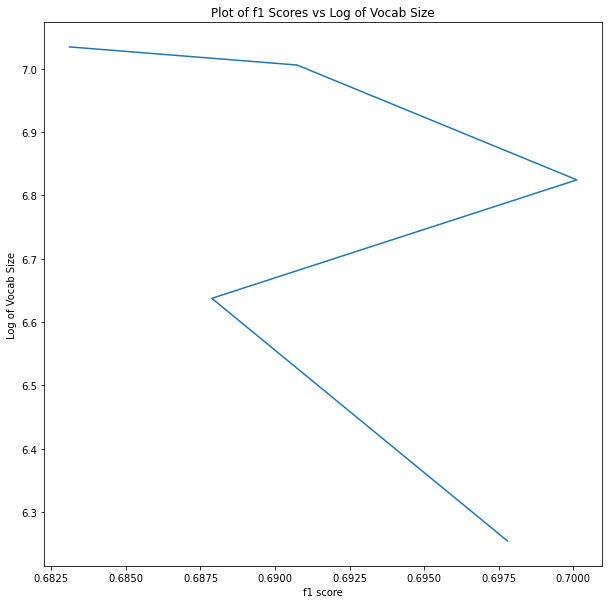

In [81]:
def P6():
    # use the transformation function from part 5- train_transform, dev_transform, vocab
    # Keep this random seed here to make comparison easier.
    #np.random.seed(0)
    
    ### STUDENT START ###
    # model with full vocabulary
    model0 = LogisticRegression(penalty="l1", tol=0.015, solver = 'liblinear', max_iter = 500)
    model0.fit(train_transform, train_labels)
    model0_predict = model0.predict(dev_transform)
    f1_score0 = metrics.f1_score(dev_labels, model0_predict, average = 'weighted')
    print('Model with full vocab')
    print('THE f1 SCORE= ', np.round(f1_score0,4), ', & THE VOCAB SIZE= ', len(vocab))


    #model 1
    strengths = [0.3, 0.5, 0.7, 0.9, 1]
    vocab_for_plot = []
    scores = []
    for x in strengths:
        model1 = LogisticRegression(penalty="l1", tol=0.015, C=x, solver = 'liblinear', max_iter = 500)
        model1.fit(train_transform, train_labels)
        model1_predict = model1.predict(dev_transform)
        f1_score = metrics.f1_score(dev_labels, model1_predict, average = 'weighted')
        scores.append(f1_score)
    #np.apply_along_axis(np.count_nonzero, 1, model1.coef_)
        nonzero = (model1.coef_ != 0)
        keeping = nonzero.any(axis = 0)
        fix_train = train_transform[:, keeping]
        vocab_size = fix_train.shape[1]
        fix_dev = dev_transform[:, keeping]
        vocab_for_plot.append(np.log(vocab_size))
        print('L1 models:')
        print('FOR REGULARIZATION STRENGTH= ', x, ', THE f1 SCORE= ', np.round(f1_score,4), ', & THE VOCAB SIZE= ', vocab_size)
    
    #model 2
    model2 = LogisticRegression(penalty = 'l2', tol=0.015, C= 0.5, max_iter = 500)
    model2.fit(fix_train, train_labels)
    model2_predict = model2.predict(fix_dev)
    f1_score2 = metrics.f1_score(dev_labels, model2_predict, average = 'weighted')
    print('\n')
    print('L2 models:')
    print('FOR REGULARIZATION STRENGTH= ', 0.5, ', THE f1 SCORE= ', np.round(f1_score2,4))
    print('\n')

    plt.figure(figsize = (10,10))
    plt.plot(scores, vocab_for_plot)
    plt.xlabel('f1 score')
    plt.ylabel('Log of Vocab Size')
    plt.title('Plot of f1 Scores vs Log of Vocab Size')
    plt.show()
    
    ### STUDENT END ###

P6()

ANSWER: How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

It seems that as the vocabularly increases, the f1 score increases as well - meaning that the performance improves. However, after the regularization hits 0.7, the f1 score and performance begin to change direction and get worse. When we use 'full vocabulary', the f1 score is 0.6991- we see that when the vocab size decreases when the regularization is set to 0.7, there is a slight improvement in the f1 score. 



### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [82]:
def tvect(data1, data2):
    vect = TfidfVectorizer()
    vect1 = vect.fit_transform(data1)
    vect2 = vect.transform(data2)
    return [vect1, vect2]

tvect_train = tvect(train_data, dev_data)[0]
tvect_dev = tvect(train_data, dev_data)[1]

In [90]:
def P7(data1, data2, vectorizer, show_Rratio_docs):
    ### STUDENT START ###
    if vectorizer == 'Tfidf':
        modelv = LogisticRegression(penalty = 'l2', tol=0.015, C=100, solver="liblinear", multi_class="auto")
        modelv.fit(data1, train_labels)
        model_predictv = modelv.predict(data2)
        f1_scorev = metrics.f1_score(dev_labels, model_predictv, average = 'weighted')
        print('USING TFIDFVECTORIZER')
        print('THE f1 SCORE OF THIS MODEL: ', f1_scorev)
        
        if show_Rratio_docs == True:
            probs = modelv.predict_proba(data2)

            R, difficult_docs, index_docs = [], [], []
    
            for i in range(probs.shape[0]):
                R.append(max(probs[i]) / probs[i][dev_labels[i]])
                most_diff = sorted(R, reverse=True)[:3]
    
            for i in range(len(most_diff)):
                difficult_docs.append(dev_data[int(np.where(R == most_diff[i])[0])])
                index_docs.append(int(np.where(R == most_diff[i])[0]))
    
            difficult_predict = model_predictv[index_docs]
            difficult_correct = dev_labels[index_docs]        
        
            for document in range(len(difficult_docs)):
                print('\n')
                print("NUMBER {} : DOCUMENT WITH THE HIGHEST R RATIO".format(document + 1))
                topics = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
                print("PREDICTED LABEL: {}".format(topics[difficult_predict[document]]))
                print("TRUE LABEL: {}".format(topics[difficult_correct[document]]))
                print(difficult_docs[document])
                print("\n")
                
            
    
    else: 
        model = LogisticRegression(penalty = 'l2', tol=0.015, C=100, solver="liblinear", multi_class="auto")
        model.fit(data1, train_labels)
        model_predict = model.predict(data2)
        f1_score = metrics.f1_score(dev_labels, model_predict, average = 'weighted')
        print('USING COUNTVECTORIZER')
        print('THE f1 SCORE OF THIS MODEL: ', f1_score)
        
    ### STUDENT END ###


#data transformed by the CountVectorizer
P7(train_transform, dev_transform, 'Count', False)  
print('\n')
# data transformed by the TfidfVectorizer 
P7(tvect_train, tvect_dev, 'Tfidf', True)

USING COUNTVECTORIZER
THE f1 SCORE OF THIS MODEL:  0.6964469383388671


USING TFIDFVECTORIZER
THE f1 SCORE OF THIS MODEL:  0.7585494343942512


NUMBER 1 : DOCUMENT WITH THE HIGHEST R RATIO
PREDICTED LABEL: talk.religion.misc
TRUE LABEL: sci.space
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actua

ANSWER: How is TfidfVectorizer different than CountVectorizer?
CountVectorizer counts word frequencies which can be problematic because it does not recognize more rare words (ie- 'we', 'the', 'and' might occur a lot and don't tell us much about the text where as 'religion' or 'space' can be more indicative of the document topic). In contrast, TfidVectorizer weights word counts based on how often the appear in the text, which can account for words that are more telling of the document's topic.

Explain what the R ratio describes. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see. 
The R ratio describes which documents are the most difficult to classify. 
One issue seen in 2 of the 3 most difficult documents to classify, is that the model recognizes the word "Mormon" in these documents and classifies them as 'talk.religion.misc' instead of the correct label, 'sci.space'. The model makes the same mistake with other words as well- like recognizing 'space' and classifying the 2nd text as 'sci.space' when this is not the correct classification. We can assume that the model does this across the board due to the use of the TfidfVectorizer. Transforming text to word bigram vectors instead of unigram vectors might provide the model with more context to make more accurate classifications. 

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [91]:
def tvect_p8(data1, data2):
    vect = TfidfVectorizer(ngram_range= (2,2))
    vect1 = vect.fit_transform(data1)
    vect2 = vect.transform(data2)
    return [vect1, vect2]

tvect_train_p8 = tvect_p8(train_data, dev_data)[0]
tvect_dev_p8 = tvect_p8(train_data, dev_data)[1]

P7(tvect_train_p8, tvect_dev_p8, 'Tfidf', False)

USING TFIDFVECTORIZER
THE f1 SCORE OF THIS MODEL:  0.6887636810197436


Using bigram feature vectors does not improve the performance of the model.